In [1]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
import implicit
from tqdm.notebook import trange
import pandas as pd
from implicit.als import AlternatingLeastSquares
import torch

In [ ]:
train_zvuk = pd.read_parquet('train_zvuk.parquet')

train_smm = pd.read_parquet('train_smm.parquet')

test_smm = pd.read_parquet('test_smm.parquet')

test_zvuk = pd.read_parquet('test_zvuk.parquet')

In [156]:
train_zvuk = train_zvuk[train_zvuk['rating']<=10]
train_smm = train_smm[train_smm['rating']<=10]
test_smm = test_smm[test_smm['rating']<=10]
test_zvuk = test_zvuk[test_zvuk['rating']<=10]

In [157]:
u_ids_z = set(train_zvuk.user_id.unique())
u_ids_s = set(train_smm.user_id.unique())
US_ID = u_ids_z.intersection(u_ids_s)
len(US_ID)

35278

In [158]:
u_test_z = set(test_zvuk.user_id.unique())
u_test_s = set(test_smm.user_id.unique())
US_VAL = (u_ids_z - u_test_z).intersection(u_ids_s-u_test_s)
len(US_VAL)


853

In [159]:
type(US_VAL)

set

In [160]:
val_zvuk = train_zvuk[train_zvuk['user_id'].isin(US_VAL)].sort_values(by='user_id', ascending=False)
val_smm = train_smm[train_smm['user_id'].isin(US_VAL)].sort_values(by='user_id', ascending=False)

train_z = train_zvuk[train_zvuk['user_id'].isin(US_ID)].sort_values(by='user_id', ascending=False)
train_s = train_smm[train_smm['user_id'].isin(US_ID) ].sort_values(by='user_id', ascending=False)



RET_Z, RET_S = train_zvuk.user_id.unique(), train_smm.user_id.unique()


In [168]:
import numpy as np

# Создаем пример массива
array = np.array([1, 2, 3])

# Заданное значение для поиска
X = 3

# Находим индексы, где элементы равны X
indices = np.where(array == X)[0][0]  # [0] для получения индексов

# Выводим индексы
print(f'Индексы, где элементы равны {X}: {indices}')

Индексы, где элементы равны 3: 2


In [163]:
RET_Z

array([6486258, 7436216, 1736489, ..., 1005181, 2002945, 8820532],
      dtype=int64)

In [15]:
def pivot_csr(df):
    row_indices = pd.factorize(df['user_id'])[0]
    col_indices = pd.factorize(df['item_id'])[0]
    
    # Создаем CSR-матрицу
    csr_result = csr_matrix((df['rating'], (row_indices, col_indices)), 
                         shape=(len(df['user_id'].unique()), len(df['item_id'].unique())))
    return csr_result

val_zvuk_csr = pivot_csr(val_zvuk)
val_smm_csr = pivot_csr(val_smm)
train_z_csr = pivot_csr(train_z)
train_s_csr = pivot_csr(train_s)


In [16]:
for el in [val_zvuk_csr, val_smm_csr, train_z_csr, train_s_csr]:
    print(el.shape)

(853, 40207)
(853, 46044)
(35278, 106407)
(35278, 166307)


In [127]:
df_z = train_z_csr
R = df_z
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z = model.user_factors  # Размер (num_users, 10)
item_factors_z = model.item_factors  # Размер (num_items, 10)
R = train_s_csr
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_s = model.user_factors  # Размер (num_users, 10)
item_factors_s = model.item_factors  # Размер (num_items, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [128]:
df_z_val = val_zvuk_csr
R = df_z_val
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z_val = model.user_factors  # Размер (num_users, 10)
item_factors_z_val = model.item_factors  # Размер (num_items, 10)
R = val_smm_csr
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_s_val = model.user_factors  # Размер (num_users, 10)
item_factors_s_val = model.item_factors  # Размер (num_items, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [129]:
X_train = []
y_train = []
for user in trange(df_z.shape[0]):
    for item in range(df_z.shape[1]):
        if df_z[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_train.append(np.concatenate((user_factors_z[user],item_factors_z[item],user_factors_s[user]), axis=0))  # Добавляем в X_train вектор пользователя
            y_train.append(df_z[user, item])  # Добавляем значение в y_train
        if len(X_train)>=50000:
            break
    if len(X_train)>=50000:
            break
              

  0%|          | 0/35278 [00:00<?, ?it/s]

In [131]:
X_train = torch.tensor(np.array(X_train)).float()

y_train = torch.tensor(np.array(y_train)).float()

mean = y_train.mean()
std = y_train.std()

# Стандартизация
y_train = (y_train - mean) / std

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определение модели
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(900, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)  # Выходной слой без активации
        return x

# Инициализация модели, функции потерь и оптимизатора
model_nn_z1 = FullyConnectedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn_z1.parameters(), lr=0.001)

# Пример данных
# Замените на ваши данные

# Цикл обучения
num_epochs = 20  # Количество эпох
batch_size = 32
LOSS=[]
for epoch in trange(num_epochs):
    l_s=0
    for i in range(0, len(y_train), batch_size):
        model_nn_z1.train()  # Установка модели в режим обучения
    
        # Прямой проход
        outputs = model_nn_z1(X_train[i:i+batch_size])
        loss = criterion(outputs.flatten(), y_train[i:i+batch_size])
    
        # Обратный проход и оптимизация
        optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()        # Вычисление градиентов
        optimizer.step()       # Обновление весов
    
        # Вывод информации о ходе обучения
        l_s+=loss*batch_size/len(y_train)
    LOSS.append(l_s.detach().numpy())


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(LOSS)

In [64]:
VALIDATION

NameError: name 'VALIDATION' is not defined

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [134]:
X_val = []
y_val = []
for user in trange(df_z_val.shape[0]):
    for item in range(df_z_val.shape[1]):
        if df_z_val[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_val.append(np.concatenate((user_factors_z_val[user],item_factors_z_val[item],user_factors_s_val[user]), axis=0))  # Добавляем в X_train вектор пользователя
            y_val.append(df_z_val[user, item])  # Добавляем значение в y_train
        if len(X_val)>=50000:
            break
    if len(X_val)>=50000:
            break
              

  0%|          | 0/853 [00:00<?, ?it/s]

In [135]:
X_val = torch.tensor(np.array(X_val)).float()
y_val = torch.tensor(np.array(y_val)).float()

mean = y_val.mean()
std = y_val.std()

# Стандартизация
y_val = (y_val - mean) / std

In [140]:
model_nn_z1.eval()  # Устанавливаем модель в режим оценки
total_loss = 0.0

with torch.no_grad():  # Отключаем градиенты для валидации
    for i in range(0, len(y_val), batch_size):         
        outputs = model_nn_z1(X_val[i:i+batch_size])  # Получаем предсказания модели
        loss = criterion(outputs.flatten(), y_val[i:i+batch_size])  # Вычисляем потерю
        total_loss += loss.item() 

average_loss = total_loss*batch_size / len(y_val)  # Средняя потеря

In [141]:
average_loss

5.76751309203662

In [142]:
outputs.flatten()

tensor([-1.8046, -1.6832, -1.7683, -1.7708, -1.8032, -1.6676, -1.7337, -1.5873,
         0.4780,  0.3049,  0.5841,  0.6153,  1.0681, -0.6134,  0.1281, -0.2657])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [84]:
df_s = train_s_csr
X_train = []
y_train = []
for user in trange(df_s.shape[0]):
    for item in range(df_s.shape[1]):
        if df_s[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_train.append(np.concatenate((user_factors_z[user],item_factors_s[item],user_factors_s[user]), axis=0))  # Добавляем в X_train вектор пользователя
            y_train.append(df_s[user, item])  # Добавляем значение в y_train
        if len(X_train)>=25000:
            break
    if len(X_train)>=25000:
            break

  0%|          | 0/35278 [00:00<?, ?it/s]

In [85]:
len(X_train)

25000

In [86]:
X_train = torch.tensor(np.array(X_train)).float()
y_train = torch.tensor(np.array(y_train)).float()

mean = y_train.mean()
std = y_train.std()

# Стандартизация
y_train = (y_train - mean) / std

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определение модели
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(900, 1000)
        self.fc3 = nn.Linear(1000, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)  # Выходной слой без активации
        return x

# Инициализация модели, функции потерь и оптимизатора
model_nn_s1 = FullyConnectedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn_s1.parameters(), lr=0.001)

# Пример данных
# Замените на ваши данные

# Цикл обучения
num_epochs = 200  # Количество эпох
batch_size = 32
LOSS=[]
for epoch in trange(num_epochs):
    l_s=0
    for i in range(0, len(y_train), batch_size):
        model_nn_s1.train()  # Установка модели в режим обучения
    
        # Прямой проход
        outputs = model_nn_s1(X_train[i:i+batch_size])
        loss = criterion(outputs.flatten(), y_train[i:i+batch_size])
    
        # Обратный проход и оптимизация
        optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()        # Вычисление градиентов
        optimizer.step()       # Обновление весов
    
        # Вывод информации о ходе обучения
        l_s+=loss*batch_size/len(y_train)
    LOSS.append(l_s.detach().numpy())


  0%|          | 0/200 [00:00<?, ?it/s]

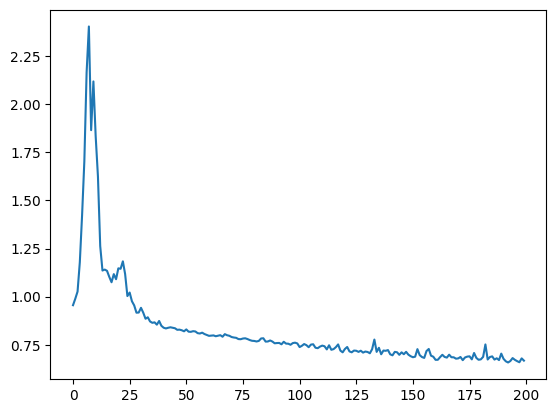

In [88]:
import matplotlib.pyplot as plt
plt.plot(LOSS)

In [92]:
X_val = torch.tensor(np.array(X_val)).float()
y_val = torch.tensor(np.array(y_val)).float()

mean = y_val.mean()
std = y_val.std()

# Стандартизация
y_val = (y_val - mean) / std

In [95]:
model_nn_s1.eval()  # Устанавливаем модель в режим оценки
total_loss = 0.0

with torch.no_grad():  # Отключаем градиенты для валидации
    for i in range(0, len(y_val), batch_size):         
        outputs = model_nn_s1(X_val[i:i+batch_size])  # Получаем предсказания модели
        loss = criterion(outputs.flatten(), y_val[i:i+batch_size])  # Вычисляем потерю
        total_loss += loss.item() 

average_loss = total_loss*batch_size / len(y_val)  # Средняя потеря

In [96]:
average_loss

35.314860303316784

In [144]:
u_ids_z = set(train_zvuk.user_id.unique())
u_ids_s = set(test_zvuk.user_id.unique())
US_ID = u_ids_z.intersection(u_ids_s)
US_VAL = u_ids_z - u_ids_s


In [145]:
val_zvuk = train_zvuk[train_zvuk['user_id'].isin(US_VAL)].sort_values(by='user_id', ascending=False)

train_z = train_zvuk[train_zvuk['user_id'].isin(US_ID)].sort_values(by='user_id', ascending=False)



val_zvuk_csr = pivot_csr(val_zvuk)

train_z_csr = pivot_csr(train_z)


In [146]:
df_z = train_z_csr
R = df_z
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z = model.user_factors  # Размер (num_users, 10)
item_factors_z = model.item_factors  # Размер (num_items, 10)
df_z_val = val_zvuk_csr
R = df_z_val
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z_val = model.user_factors  # Размер (num_users, 10)
item_factors_z_val = model.item_factors  # Размер (num_items, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [147]:
X_train = []
y_train = []
for user in trange(df_z.shape[0]):
    for item in range(df_z.shape[1]):
        if df_z[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_train.append(np.concatenate((user_factors_z[user],item_factors_z[item]), axis=0))  # Добавляем в X_train вектор пользователя
            y_train.append(df_z[user, item])  # Добавляем значение в y_train
        if len(X_train)>=50000:
            break
    if len(X_train)>=50000:
            break
              

  0%|          | 0/118057 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [148]:
X_train = torch.tensor(np.array(X_train)).float()

y_train = torch.tensor(np.array(y_train)).float()

mean = y_train.mean()
std = y_train.std()

# Стандартизация
y_train = (y_train - mean) / std

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определение модели
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(600, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)  # Выходной слой без активации
        return x

# Инициализация модели, функции потерь и оптимизатора
model_nn_z1 = FullyConnectedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn_z1.parameters(), lr=0.001)

# Пример данных
# Замените на ваши данные

# Цикл обучения
num_epochs = 200  # Количество эпох
batch_size = 32
LOSS=[]
for epoch in trange(num_epochs):
    l_s=0
    for i in range(0, len(y_train), batch_size):
        model_nn_z1.train()  # Установка модели в режим обучения
    
        # Прямой проход
        outputs = model_nn_z1(X_train[i:i+batch_size])
        loss = criterion(outputs.flatten(), y_train[i:i+batch_size])
    
        # Обратный проход и оптимизация
        optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()        # Вычисление градиентов
        optimizer.step()       # Обновление весов
    
        # Вывод информации о ходе обучения
        l_s+=loss*batch_size/len(y_train)
    LOSS.append(l_s.detach().numpy())


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [150]:
u_ids_z = set(train_smm.user_id.unique())
u_ids_s = set(test_smm.user_id.unique())
US_ID = u_ids_z.intersection(u_ids_s)
US_VAL = u_ids_z - u_ids_s


In [151]:
val_zvuk = train_smm[train_smm['user_id'].isin(US_VAL)].sort_values(by='user_id', ascending=False)

train_z = train_smm[train_smm['user_id'].isin(US_ID)].sort_values(by='user_id', ascending=False)



val_zvuk_csr = pivot_csr(val_zvuk)

train_z_csr = pivot_csr(train_z)


In [152]:
df_z = train_z_csr
R = df_z
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z = model.user_factors  # Размер (num_users, 10)
item_factors_z = model.item_factors  # Размер (num_items, 10)
df_z_val = val_zvuk_csr
R = df_z_val
model = implicit.als.AlternatingLeastSquares(factors=300, regularization=0.01, iterations=30)
model.fit(R)
user_factors_z_val = model.user_factors  # Размер (num_users, 10)
item_factors_z_val = model.item_factors  # Размер (num_items, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [153]:
X_train = []
y_train = []
for user in trange(df_z.shape[0]):
    for item in range(df_z.shape[1]):
        if df_z[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_train.append(np.concatenate((user_factors_z[user],item_factors_z[item]), axis=0))  # Добавляем в X_train вектор пользователя
            y_train.append(df_z[user, item])  # Добавляем значение в y_train
        if len(X_train)>=50000:
            break
    if len(X_train)>=50000:
            break
              

  0%|          | 0/158383 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [154]:
X_train = torch.tensor(np.array(X_train)).float()

y_train = torch.tensor(np.array(y_train)).float()

mean = y_train.mean()
std = y_train.std()

# Стандартизация
y_train = (y_train - mean) / std

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определение модели
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(600, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)  # Выходной слой без активации
        return x

# Инициализация модели, функции потерь и оптимизатора
model_nn_z1 = FullyConnectedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn_z1.parameters(), lr=0.001)

# Пример данных
# Замените на ваши данные

# Цикл обучения
num_epochs = 200  # Количество эпох
batch_size = 32
LOSS=[]
for epoch in trange(num_epochs):
    l_s=0
    for i in range(0, len(y_train), batch_size):
        model_nn_z1.train()  # Установка модели в режим обучения
    
        # Прямой проход
        outputs = model_nn_z1(X_train[i:i+batch_size])
        loss = criterion(outputs.flatten(), y_train[i:i+batch_size])
    
        # Обратный проход и оптимизация
        optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()        # Вычисление градиентов
        optimizer.step()       # Обновление весов
    
        # Вывод информации о ходе обучения
        l_s+=loss*batch_size/len(y_train)
    LOSS.append(l_s.detach().numpy())


  0%|          | 0/200 [00:00<?, ?it/s]

In [91]:
df_s_val = val_smm_csr

X_val = []
y_val = []
for user in trange(df_s_val.shape[0]):
    for item in range(df_s_val.shape[1]):
        if df_s_val[user, item] > 0:  # Проверяем наличие взаимодействия
            #print(user_factors_z.shape,item_factors_z.shape, user_factors_s.shape)
            X_val.append(np.concatenate((user_factors_z_val[user],item_factors_s_val[item],user_factors_s_val[user]), axis=0))  # Добавляем в X_train вектор пользователя
            y_val.append(df_s_val[user, item])  # Добавляем значение в y_train
        if len(X_val)>=50000:
            break
    if len(X_val)>=50000:
            break
              

  0%|          | 0/853 [00:00<?, ?it/s]

In [169]:
tensor1 = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
tensor2 = torch.tensor([[1, 6], [3, 8]], dtype=torch.float32)

# Создаем объект функции потерь
mse_loss = nn.MSELoss()

# Вычисляем потерю
loss = mse_loss(tensor1, tensor2)

In [170]:
loss

tensor(8.)

In [173]:
tensor1.shape[0]

2